# Load and play with Allen Institute reference model

This notebook loads trained weights for the 3D "reference" model from the Allen paper [1] and sets you up to take a look at the latent space.

**Note**: This is *not* the full model from the paper, but only the "reference" model. The reference model is trained only on nucleus and cell channels, not on any cellular structures. The full model uses the reference model in a way I don't understand yet.

The reference model is the top half of the network in Figure 1 in [1].

1. Johnson, Gregory R., Rory M. Donovan-Maiye, and Mary M. Maleckar. “Building a 3D Integrated Cell.” BioRxiv, December 21, 2017, 238378. https://doi.org/10.1101/238378.

## Load model and pre-trained weights

In [1]:
import pickle
import model_utils
import numpy as np
import os

from torch.autograd import Variable
import torch

%matplotlib notebook

In [2]:
parent_dir = '/root/results/integrated_cell/test_aaegan/dgx_test_v4_1/'

model_dir = parent_dir + os.sep + 'ref_model'

# Load options from the reference model training run
opt_ref = pickle.load(open('{0}/opt.pkl'.format(model_dir), 'rb'))

In [3]:
# Which GPUs we'll run on
gpu_ids = [0, 1]
opt_ref.gpu_ids = gpu_ids

In [4]:
# Load models

models, _, _, logger_ref, _ = model_utils.load_model(opt_ref.model_name, opt_ref)

Loading from /root//results/integrated_cell/test_aaegan/dgx_test_v4_1/ref_model


In [5]:
enc_ref = models['enc']
dec_ref = models['dec']

# My guess is that this loads the pre-trained tensors and tells pytorch we won't be training them (e.g., modifying the weights)
enc_ref.train(False)
dec_ref.train(False)

Dec(
  (fc): Linear(in_features=128, out_features=2048, bias=True)
  (main): Sequential(
    (0): BatchNorm3d(1024, eps=1e-05, momentum=0.1, affine=True)
    (1): PReLU(num_parameters=1)
    (2): ConvTranspose3d(1024, 1024, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), output_padding=(0, 1, 0))
    (3): BatchNorm3d(1024, eps=1e-05, momentum=0.1, affine=True)
    (4): PReLU(num_parameters=1)
    (5): ConvTranspose3d(1024, 512, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
    (6): BatchNorm3d(512, eps=1e-05, momentum=0.1, affine=True)
    (7): PReLU(num_parameters=1)
    (8): ConvTranspose3d(512, 256, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
    (9): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True)
    (10): PReLU(num_parameters=1)
    (11): ConvTranspose3d(256, 128, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
    (12): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True)
    (13): PReLU(num_parameters=1)
    (14): C

In [6]:
# Load training images
dp_ref = model_utils.load_data_provider(opt_ref.data_save_path, opt_ref.imdir, opt_ref.dataProvider)

/opt/conda/envs/pytorch-py3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Helper functions

In [7]:
from imgToProjection import imgtoprojection
from matplotlib import pyplot as plt

def tensor2img(imgs, colors=None):
    if colors is None:
            colormap = 'hsv'
            colors = plt.get_cmap(colormap)(np.linspace(0, 1, imgs.shape[1]+1))
    
    imgs = imgs.numpy()
    im_out = list()
    
    #for every image
    for i in range(0, imgs.shape[0]):
        img = imgs[i]
        
        #contrast adjust each channel
        for j in range(0, img.shape[0]):
            maxval = np.max(img[j])
            if maxval > 0:
                img[j] = img[j]/maxval
            
        
        img = imgtoprojection(np.swapaxes(img, 1, 3), proj_all=True, colors = colors, global_adjust=True)
        img = np.swapaxes(img, 0, 2)
        
        img = np.flip(np.flip(img,0), 1)
        
        #very light border between each projection
        img[:,-2:,:] = .25
        img[-2:,:,:] = .25
        
        im_out.append(img)

    img = np.concatenate(im_out, 1)

    return img

# Run Enc^r/Dec^r on an image

In [8]:
num_test_images = dp_ref.get_n_dat('test')

In [9]:
# Grab the first 10 test images
test_images = dp_ref.get_images(np.arange(0, 10), 'test')

<IPython.core.display.Javascript object>


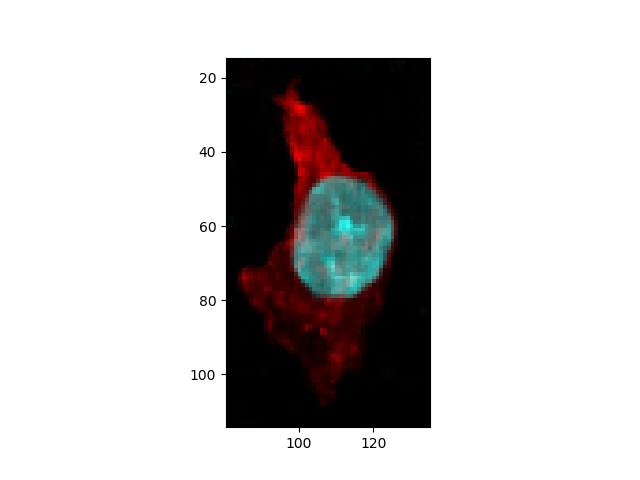

In [10]:
# Convert from tensor representation to an actual image we can look at
image = Variable(torch.unsqueeze(test_images[0], 0))

plt.imshow(tensor2img(image))

In [11]:
plt.imshow(tensor2img(image)[:,:,2])

## Encode the image

Now we'll encode the image into its latent representation.

Note that the *reference* model is only trained on the 1) cell and 2) nuclear channels, so we need to select those out of the image tensor before passing it through.

In [12]:
# There are 2 reference channels, indexed starting at 1
reference_channel_index_start = 1

plt.imshow(tensor2img(image.narrow(1, reference_channel_index_start, 2)))
z = enc_ref(image.narrow(1, reference_channel_index_start, 2))

## Decode the image

In [13]:
image_dec = dec_ref(z)

In [14]:
image_dec.shape

torch.Size([1, 2, 128, 96, 64])

In [15]:
plt.imshow(tensor2img(image_dec.cpu().detach()))

## Perturb the latent vector and see what we get!

In [31]:
# Set SNR for the perturbation
SNRs = [100, 10, 1, 0.5, 0.25, 0.125]
noise_images = []
z_0 = z[0].cpu().detach().numpy().astype(np.float32)
perturbation = np.random.randn(*z_0.shape)*np.sqrt(z_0.var()).astype(np.float32)
print(perturbation.shape)
for SNR in SNRs:   
    z_0 = z[0].cpu().detach().numpy().astype(np.float32)
    z_0_noise = z_0 + (np.random.randn(*z_0.shape)*np.sqrt(z_0.var()/SNR)).astype(np.float32)
    print(np.linalg.norm(z_0_noise))
    image_noise_dec = dec_ref([Variable(torch.from_numpy(z_0_noise).cuda())])
    noise_images.append(tensor2img(image_noise_dec.cpu().detach()))

(1, 128)
16.824135
16.461014
26.383572
27.481564
35.51524
46.765106


<IPython.core.display.Javascript object>


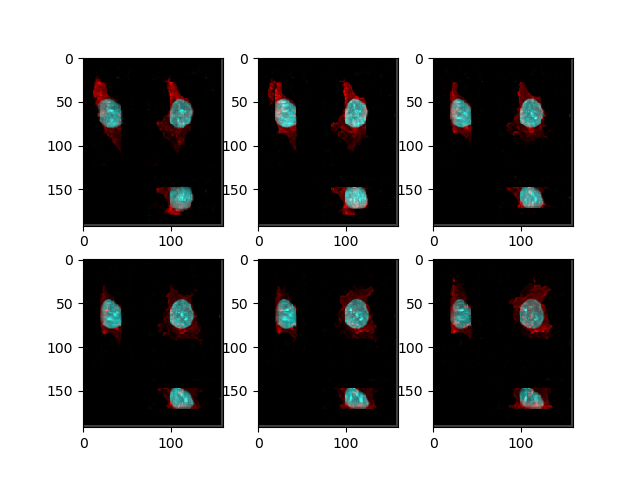

In [37]:
f, axarr = plt.subplots(2,3)
axarr[0,0].imshow(noise_images[0])
axarr[0,1].imshow(noise_images[1])
axarr[0,2].imshow(noise_images[2])
axarr[1,0].imshow(noise_images[3])
axarr[1,1].imshow(noise_images[4])
axarr[1,2].imshow(noise_images[5])

In [45]:
# Set SNR for the perturbation
thetas = np.linspace(0,np.pi/2,6, dtype = np.float32)
noise_images = []
z_0 = z[0].cpu().detach().numpy().astype(np.float32)
perturbation = np.random.randn(*z_0.shape)*np.sqrt(z_0.var()).astype(np.float32)
print(np.linalg.norm(z_0), np.linalg.norm(perturbation))
for theta in thetas:
    z_perturbed = (z_0*np.cos(theta) + perturbation*np.sin(theta)).astype(np.float32)
    print(np.linalg.norm(z_perturbed), np.linalg.norm(z_perturbed - z_0))
    image_noise_dec = dec_ref([Variable(torch.from_numpy(z_perturbed).cuda())])
    noise_images.append(tensor2img(image_noise_dec.cpu().detach()))

16.498781 15.86898203472956
16.498781 0.0
16.453247 4.9675164
16.306095 9.836745
16.111776 14.511004
15.944195 18.887787
15.868982 22.858616


<IPython.core.display.Javascript object>


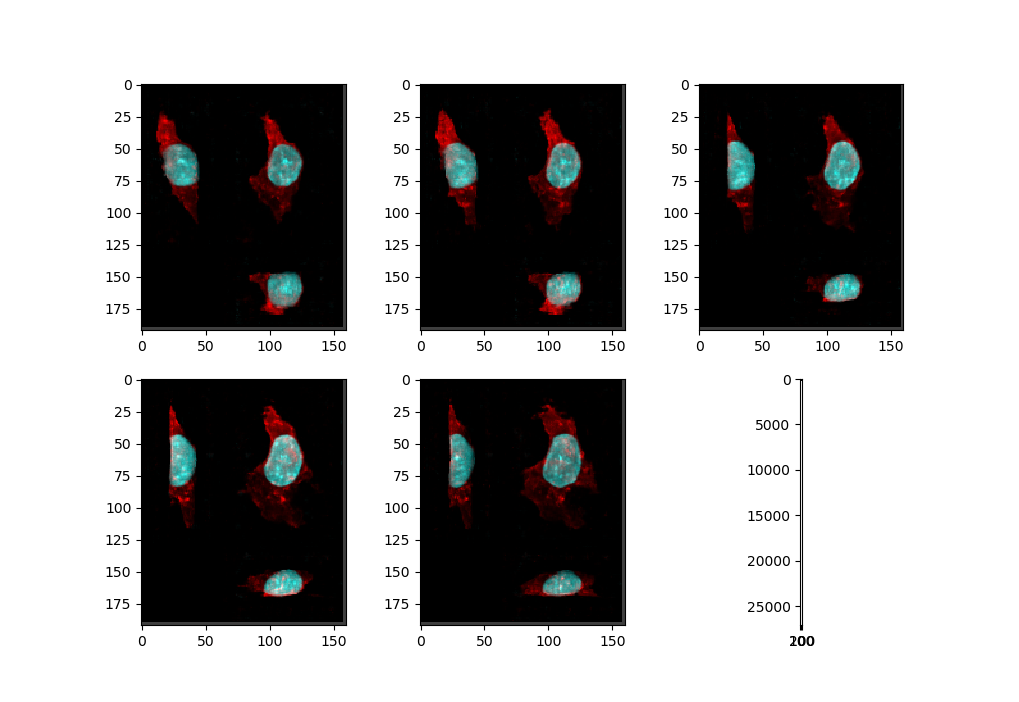

In [46]:
f, axarr = plt.subplots(2,3)
axarr[0,0].imshow(noise_images[0])
axarr[0,1].imshow(noise_images[1])
axarr[0,2].imshow(noise_images[2])
axarr[1,0].imshow(noise_images[3])
axarr[1,1].imshow(noise_images[4])
axarr[1,2].imshow(noise_images[5])

In [49]:
noise_images[:,:,0]

TypeError: list indices must be integers or slices, not tuple

In [63]:
[np.sum(noise_images[i][:,:,1] > 0.01) for i in range(len(noise_images))]

[3767, 3753, 3383, 3387, 3368, 3484]

<IPython.core.display.Javascript object>


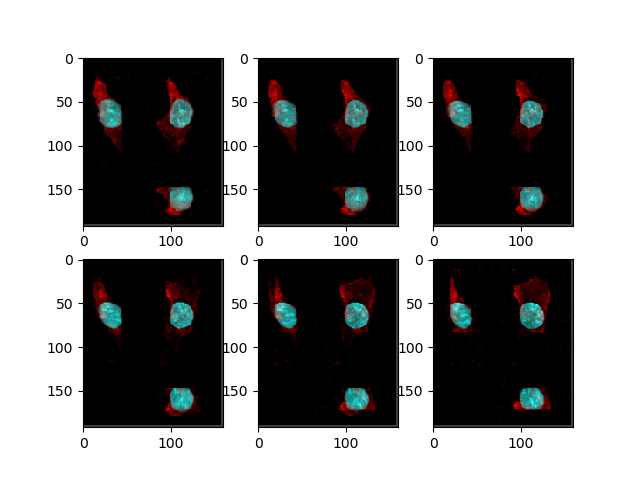

In [40]:
f, axarr = plt.subplots(2,3)
axarr[0,0].imshow(noise_images[0])
axarr[0,1].imshow(noise_images[1])
axarr[0,2].imshow(noise_images[2])
axarr[1,0].imshow(noise_images[3])
axarr[1,1].imshow(noise_images[4])
axarr[1,2].imshow(noise_images[5])